In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_abs_diff_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_dense_512_128_32_8_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_max_pool_64_32_16_8_stride_4_B1H_Inst_center_scale_10

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_129_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_129_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_129_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"],
                                  return_meta=True)
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"],
                                       return_meta=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           960       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

Apr/30 20:32:15 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
Apr/30 20:32:15 pyobsbox.generator INFO: ts_length: 63488
Apr/30 20:32:15 pyobsbox.generator INFO: shuffle: True
Apr/30 20:32:15 pyobsbox.generator INFO: seed: 42
Apr/30 20:32:15 pyobsbox.generator INFO: batch_size: 7936
Apr/30 20:32:15 pyobsbox.generator INFO: sequence_length: 2048
Apr/30 20:32:15 pyobsbox.generator INFO: n_bunches: 256
Apr/30 20:32:15 pyobsbox.generator INFO: __len__: 549
Apr/30 20:32:15 pyobsbox.generator INFO: fetched_log_folder: None
Apr/30 20:32:15 pyobsbox.generator INFO: fetched_log_prefix: 
Apr/30 20:32:15 pyobsbox.generator INFO: normalization: min_max
Apr/30 20:32:15 pyobsbox.generator INFO: normalization_pre_split: False
Apr/30 20:32:15 pyobsbox.generator INFO: normalization_kwargs: {}
Apr/30 20:32:15 pyobsbox.generator INFO: abs_diff: False
Apr/30 20:32:15 pyobsbox.generator INFO: diff: False
Apr/30 20:32:15 pyobsbox

In [9]:
print(train_metadata.shape)
train_metadata.head()

(140544, 11)


type  fill  beam plane  q           date_time  \
7245523  Inst  6254     1     h  7 2017-09-29 05:26:15   
6888517  Inst  6956     1     h  7 2018-07-21 09:11:54   
1617205  Inst  6663     1     h  7 2018-05-10 15:13:15   
6141380  Inst  7466     1     h  7 2018-11-22 20:57:15   
593330   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7245523  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6254/...        292   
6888517  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6956/...        780   
1617205  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6141380  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7466/...        670   
593330   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7245523        163.0          70.0      65536  
6888517        777.0         551.0      65536  
1617205       1122.0         794.0      65536  
6141380       1266.0         268.0      65536  
593330        1705.0         937.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(1280, 11)


type  fill  beam plane  q           date_time  \
8354486  Inst  6255     1     h  7 2017-09-29 19:31:15   
8364466  Inst  7045     1     h  7 2018-08-11 23:07:48   
938651   Inst  7454     1     h  7 2018-11-19 01:08:16   
4999011  Inst  6654     1     h  7 2018-05-07 22:15:06   
4882112  Inst  7135     1     h  7 2018-09-07 18:43:44   

                                                      file  n_bunches  \
8354486  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/...       1916   
8364466  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7045/...        108   
938651   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7454/...        648   
4999011  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6654/...        924   
4882112  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7135/...       1068   

         bunch_index  bunch_number  ts_length  
8354486       1194.0         656.0      65536  
8364466        127.0          71.0      65536  
938651        2263.0         422.0      65536  
4999011        559.0         394.0      65536  
4882112       1165.0         849.0      65536

# Loss functions

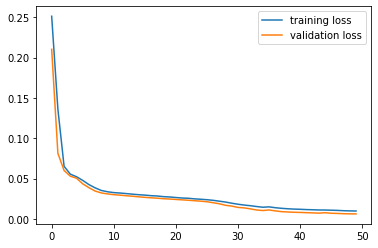

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
temp_train = [train_generator[i] for i in tqdm(range(50))]
train_dataset = np.vstack([data[0] for data in temp_train])
train_dataset.shape

bunch_sorted_index: [2 0 1]
group_bunches: [418. 966. 194.]
group_bunches sorted: [194. 418. 966.]
restore_index: [1 2 0]
group_bunches restored: [418. 966. 194.]
bunch_sorted_index: [0 1 2]
group_bunches: [ 427.  925. 2319.]
group_bunches sorted: [ 427.  925. 2319.]
restore_index: [0 1 2]
group_bunches restored: [ 427.  925. 2319.]
bunch_sorted_index: [2 1 0]
group_bunches: [467. 364.  87.]
group_bunches sorted: [ 87. 364. 467.]
restore_index: [2 1 0]
group_bunches restored: [467. 364.  87.]
bunch_sorted_index: [1 0 2]
group_bunches: [2344. 1398. 2605.]
group_bunches sorted: [1398. 2344. 2605.]
restore_index: [1 0 2]
group_bunches restored: [2344. 1398. 2605.]
bunch_sorted_index: [0 1 2]
group_bunches: [  76. 1788. 2450.]
group_bunches sorted: [  76. 1788. 2450.]
restore_index: [0 1 2]
group_bunches restored: [  76. 1788. 2450.]



(396800, 2048, 2)

In [13]:
train_dataset_meta = pd.concat([meta[1] for meta in temp_train])
train_dataset_meta.shape

(396800, 12)

In [14]:
del temp_train

In [15]:
temp_validation = [validation_generator[i] for i in tqdm(range(5))]
validation_dataset = np.vstack([data[0] for data in temp_validation])
validation_dataset.shape

(39680, 2048, 2)

In [16]:
validation_dataset_meta = pd.concat([meta[1] for meta in temp_validation])
validation_dataset_meta.shape

(39680, 12)

In [17]:
del temp_validation

# Predictions

In [18]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 60s 1s/step


(396800, 2048, 2)

In [19]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 5s 984ms/step


(39680, 2048, 2)

In [20]:
MAE_train = abs(train_pred - train_dataset).mean(axis=(1, 2)).squeeze()
MAE_train.shape

(396800,)

In [21]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=(1, 2)).squeeze()
MAE_validation.shape

(39680,)

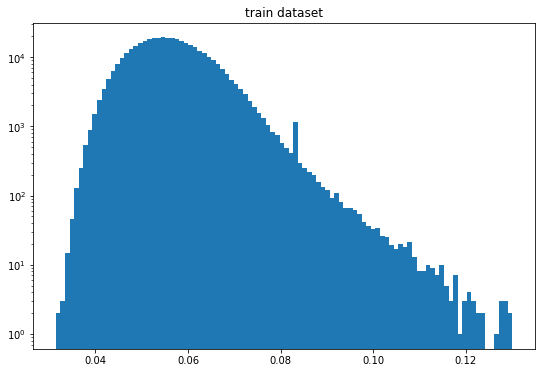

In [22]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [23]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.054124054016558294

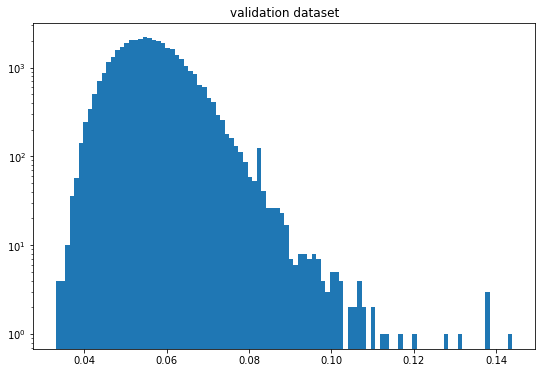

In [24]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [25]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.05417371459112281

In [26]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [27]:
max_MAE_indices

array([ 22220, 122681, 150899, ..., 209803, 155845, 379885])

In [30]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal[:, 0])
    axes[0].plot(pred_signal[:, 0])

    axes[1].plot(true_signal[:, 1])
    axes[1].plot(pred_signal[:, 1])
#     axes[1].plot(np.abs(np.diff(true_signal)))
#     axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

from pathlib import Path
from pyobsbox.utils import H5_PLANE_KEY
from pyobsbox import DB
import h5py

db = DB()

def load_plot(filepath: str, bunch_index: int):
    
    file_data = db._extract_columns(filepath)
    beam_key = "B{}".format(file_data["beam"])
    plane_key = H5_PLANE_KEY[file_data["plane"]]
    with h5py.File(filepath, "r") as h5_file:
        ob_data = h5_file[beam_key][plane_key]
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(ob_data[:, bunch_index])

index:  22220
MAE:  0.13006304876850244
n_bunches       780
bunch_index     800
bunch_number    574
chunk            10
Name: 2607, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7088/instability_data/07088_Inst_B1H_Q7_20180826_04h25m50s.h5


(18432.0, 24576.0)

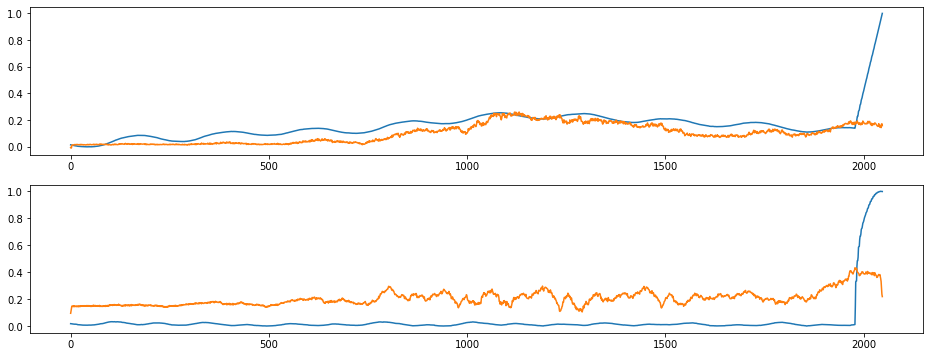

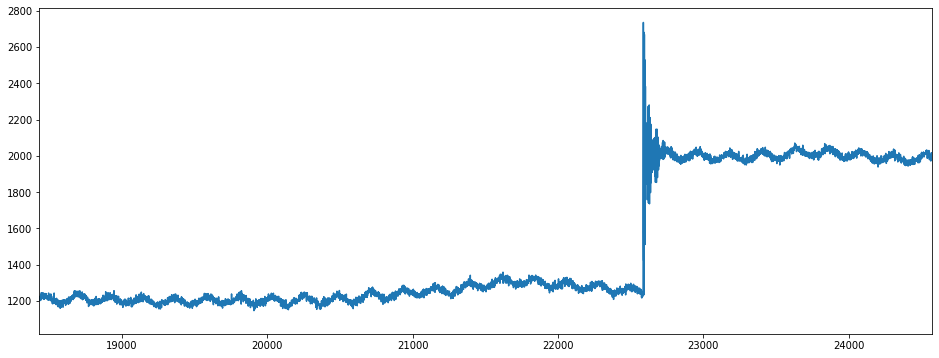

In [38]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_dataset_meta.iloc[anomalous_index]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal)
load_plot(metadata_row['file'], metadata_row['bunch_index'])

signal_chunk = metadata_row['chunk']
plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])

# Top rightmost signals

index:  22220
MAE:  0.13006304876850244
n_bunches       780
bunch_index     800
bunch_number    574
chunk            10
Name: 2607, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7088/instability_data/07088_Inst_B1H_Q7_20180826_04h25m50s.h5


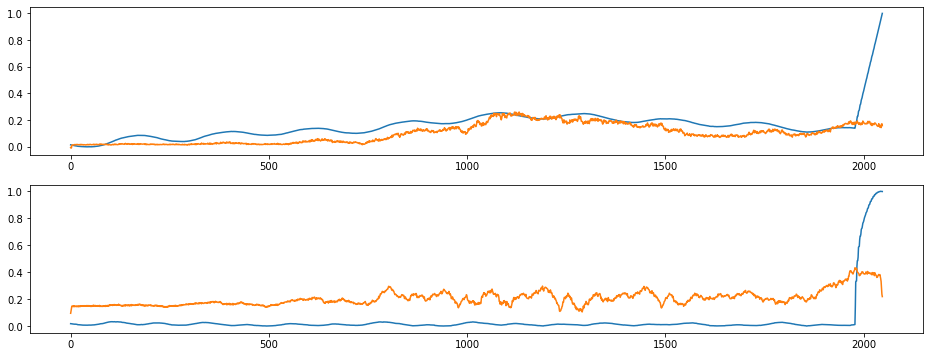

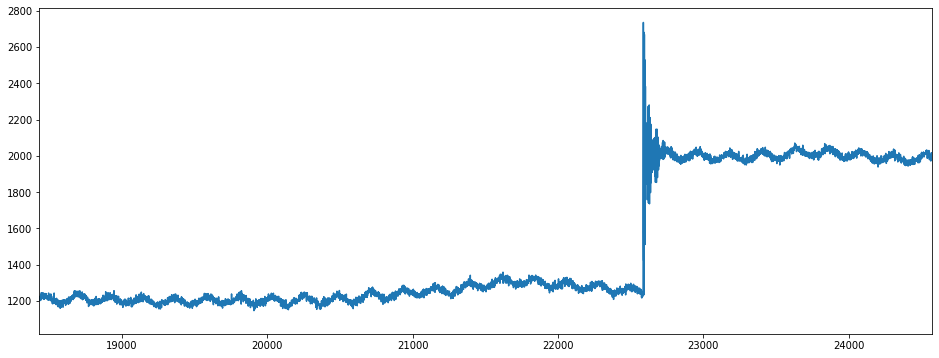

index:  122681
MAE:  0.12975996100187842
n_bunches       158
bunch_index     378
bunch_number    122
chunk            30
Name: 7790, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6797/instability_data/06797_Inst_B1H_Q7_20180615_00h00m14s.h5


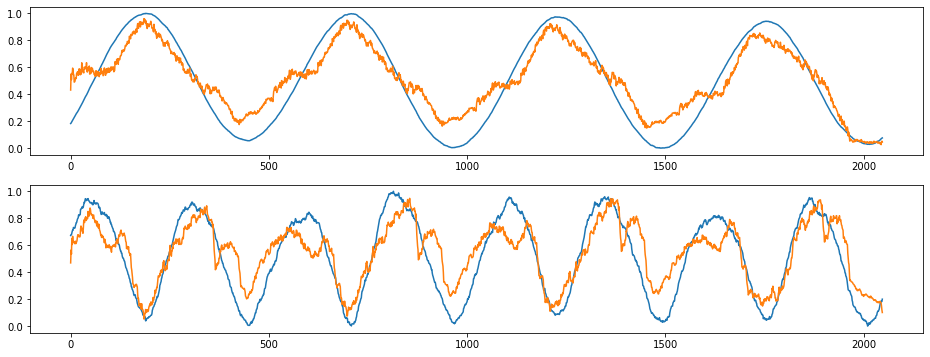

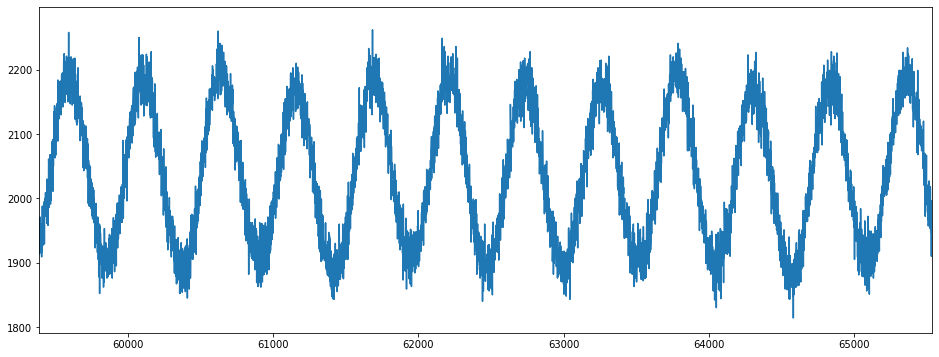

index:  150899
MAE:  0.1290591508597357
n_bunches       1868
bunch_index      136
bunch_number      56
chunk             19
Name: 4980, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6347/instability_data/06347_Inst_B1H_Q7_20171030_11h39m13s.h5


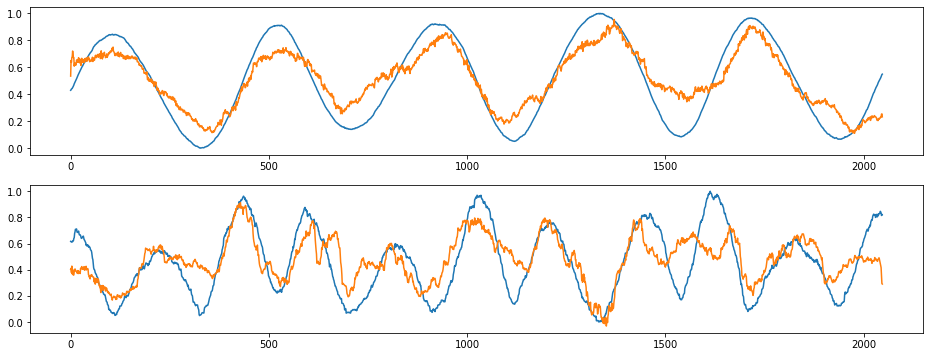

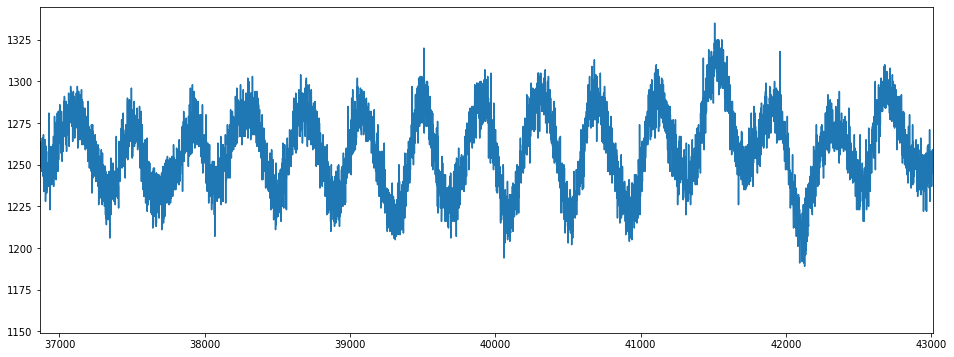

index:  45695
MAE:  0.12900722833405326
n_bunches       108
bunch_index      74
bunch_number     25
chunk            11
Name: 2932, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6922/instability_data/06922_Inst_B1H_Q7_20180714_18h34m26s.h5


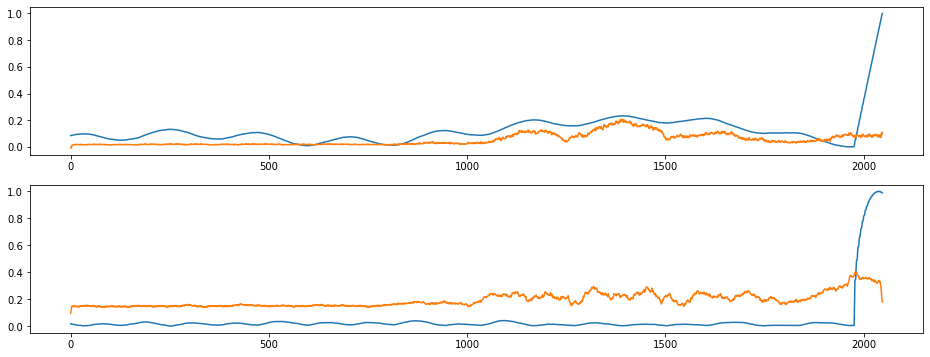

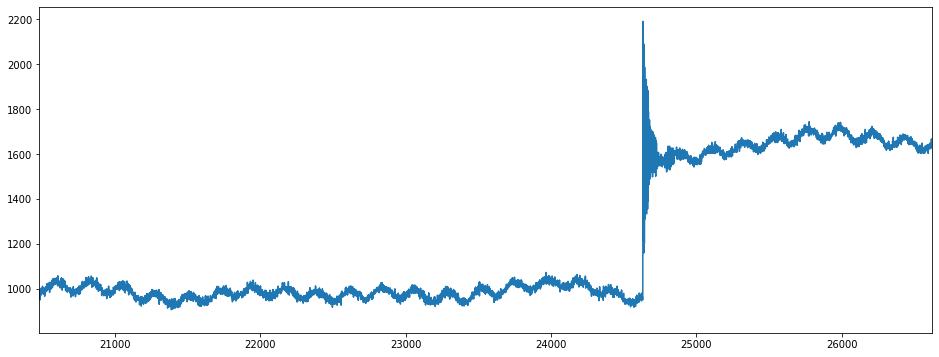

index:  59870
MAE:  0.12893278541554792
n_bunches       924
bunch_index     789
bunch_number    563
chunk            11
Name: 2856, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7055/instability_data/07055_Inst_B1H_Q7_20180814_16h02m03s.h5


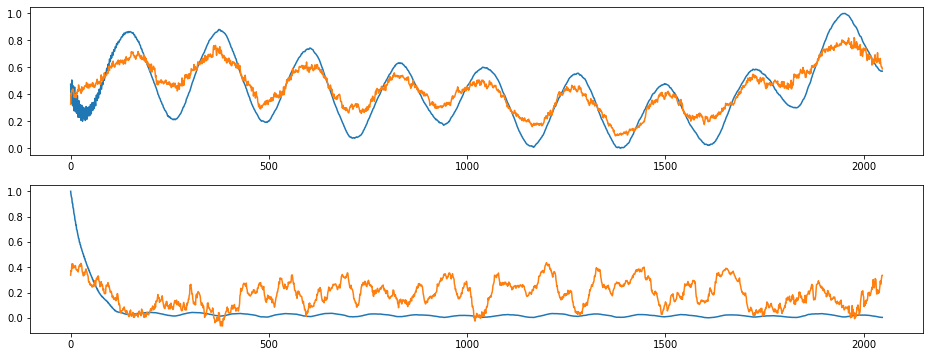

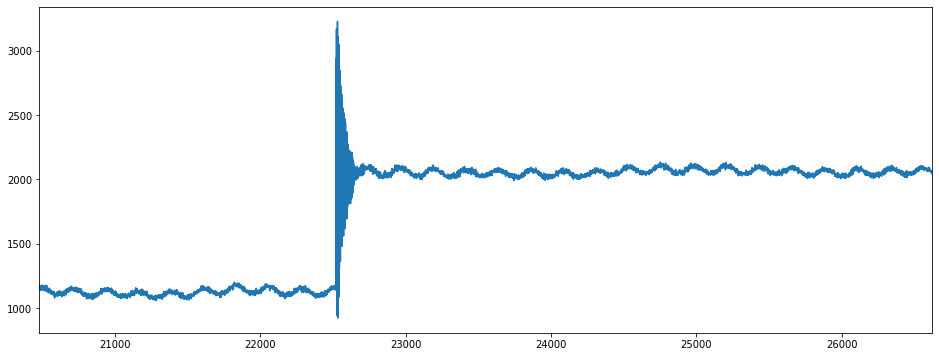

index:  161222
MAE:  0.12808818605546057
n_bunches       444
bunch_index      23
bunch_number      5
chunk             4
Name: 1155, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_10h03m14s.h5


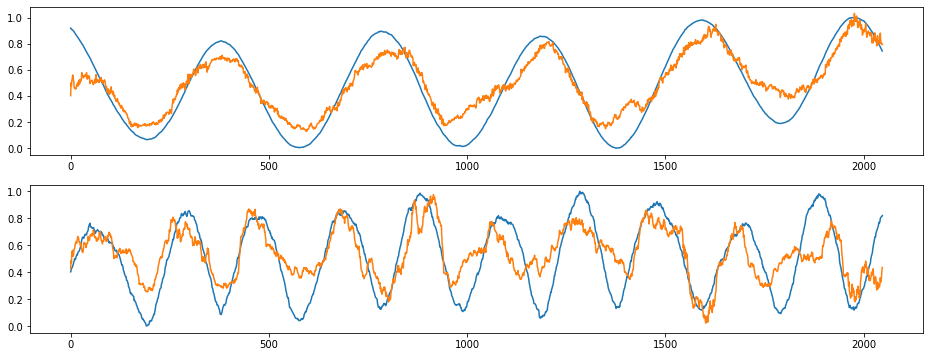

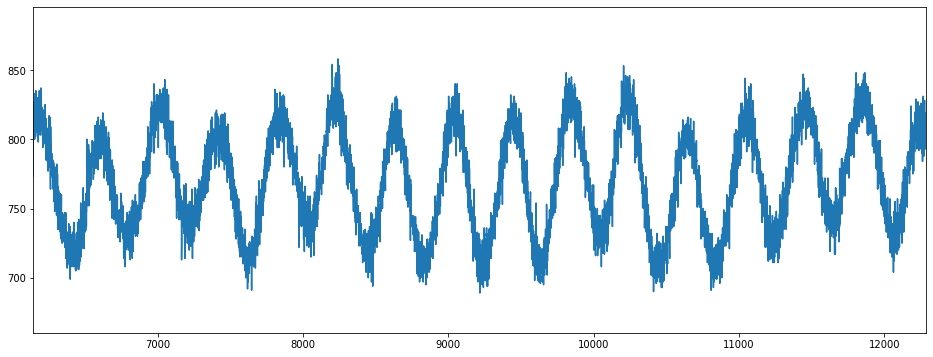

index:  120967
MAE:  0.12803710544502003
n_bunches       158
bunch_index     378
bunch_number    122
chunk            14
Name: 3694, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6797/instability_data/06797_Inst_B1H_Q7_20180615_00h00m14s.h5


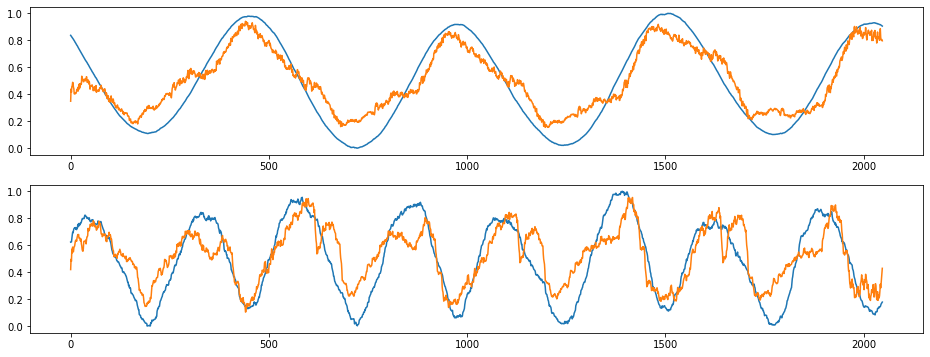

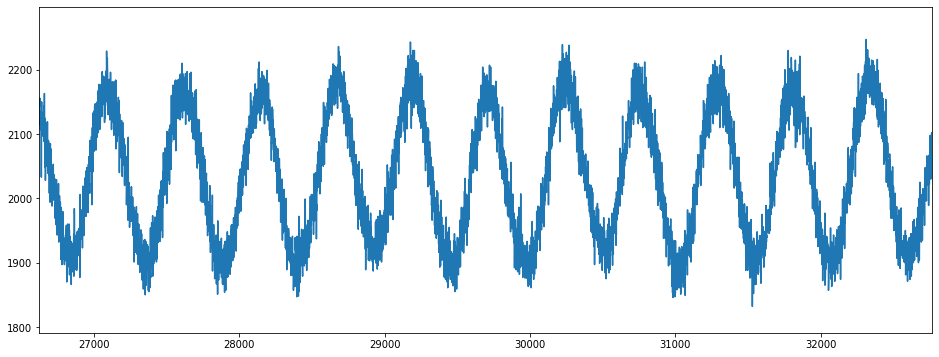

index:  324332
MAE:  0.12797773076623942
n_bunches       444
bunch_index     601
bunch_number    328
chunk            23
Name: 5950, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_10h03m14s.h5


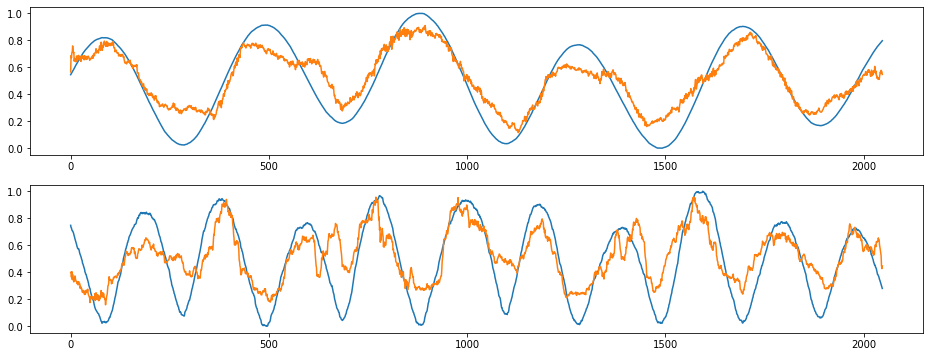

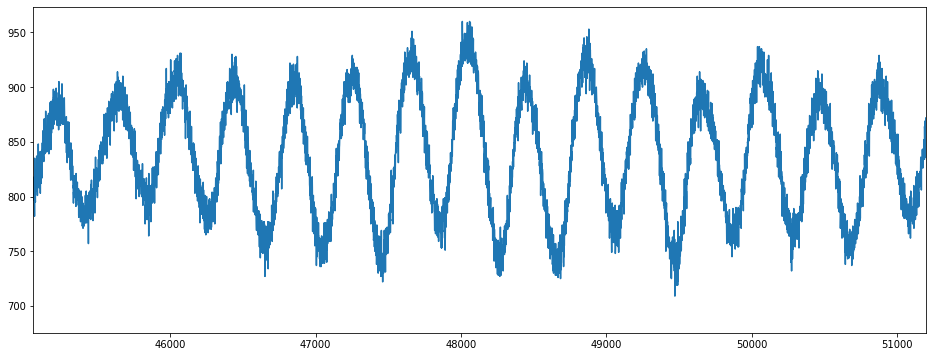

index:  161742
MAE:  0.12675729361417384
n_bunches       444
bunch_index      23
bunch_number      5
chunk             6
Name: 1667, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6990/instability_data/06990_Inst_B1H_Q7_20180727_10h03m14s.h5


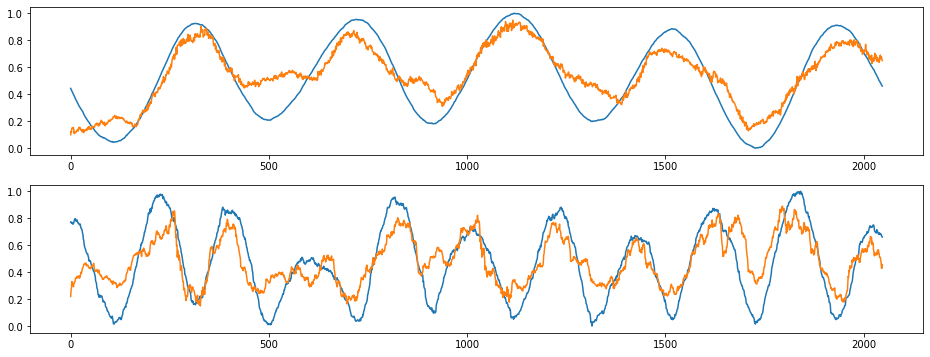

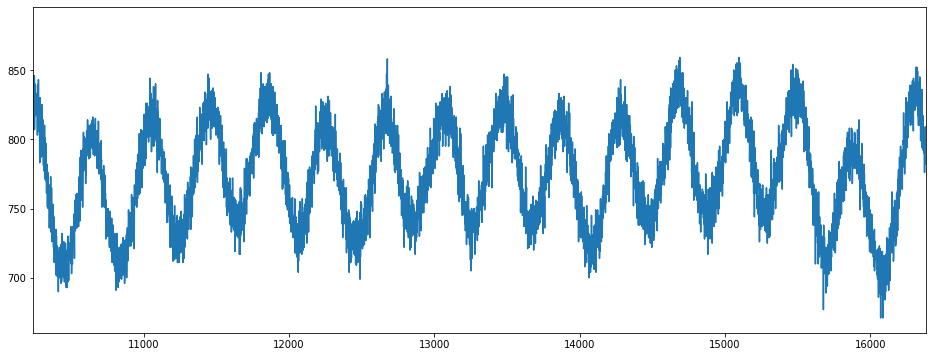

index:  353193
MAE:  0.12413209919597615
n_bunches       157
bunch_index     403
bunch_number    146
chunk            21
Name: 5465, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6799/instability_data/06799_Inst_B1H_Q7_20180615_07h45m14s.h5


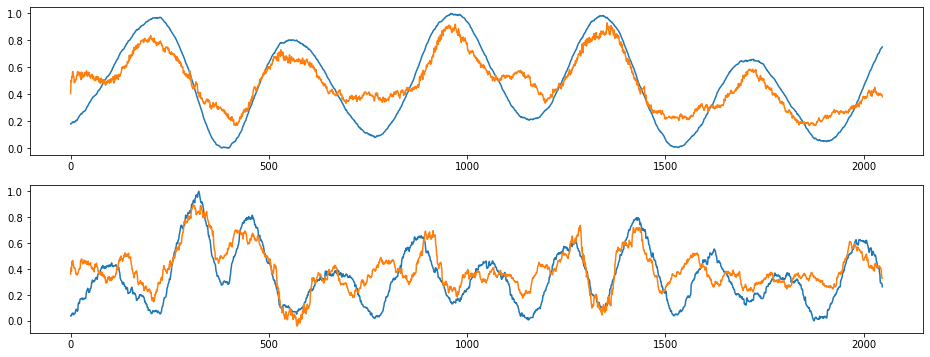

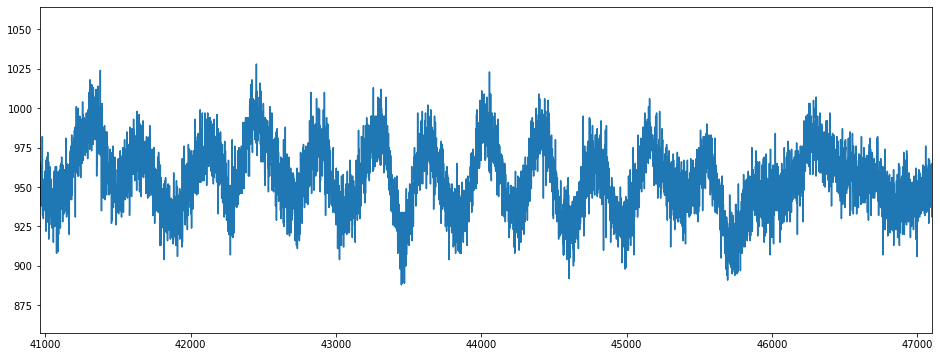

In [43]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Top leftmost signals

index:  379885
MAE:  0.03144097766208147
n_bunches       1868
bunch_index      855
bunch_number     450
chunk             17
Name: 4415, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6370/instability_data/06370_Inst_B1H_Q7_20171109_02h32m14s.h5


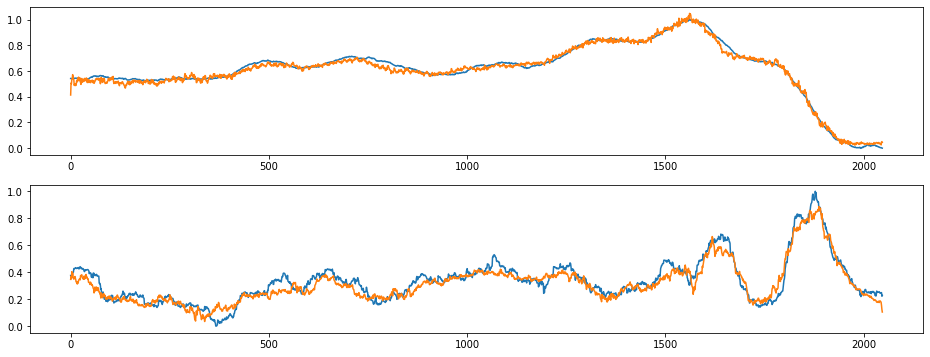

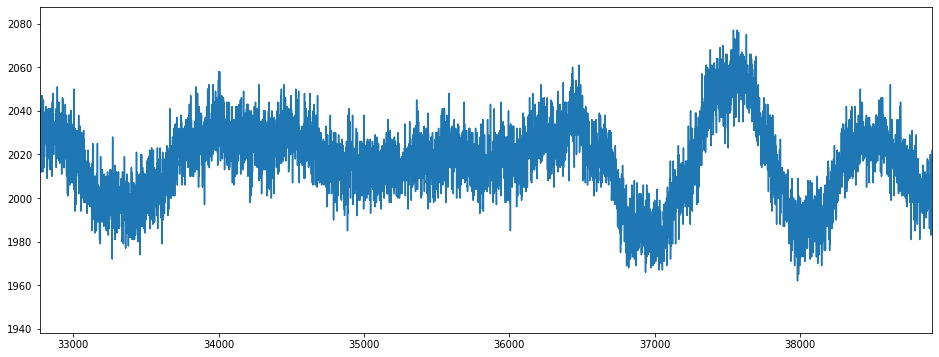

index:  155845
MAE:  0.031784643728447165
n_bunches       1916
bunch_index       64
bunch_number      22
chunk             28
Name: 7385, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6243/instability_data/06243_Inst_B1H_Q7_20170926_08h19m14s.h5


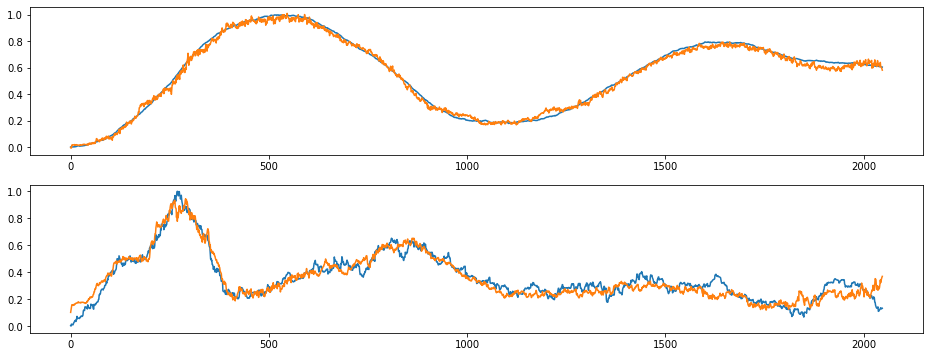

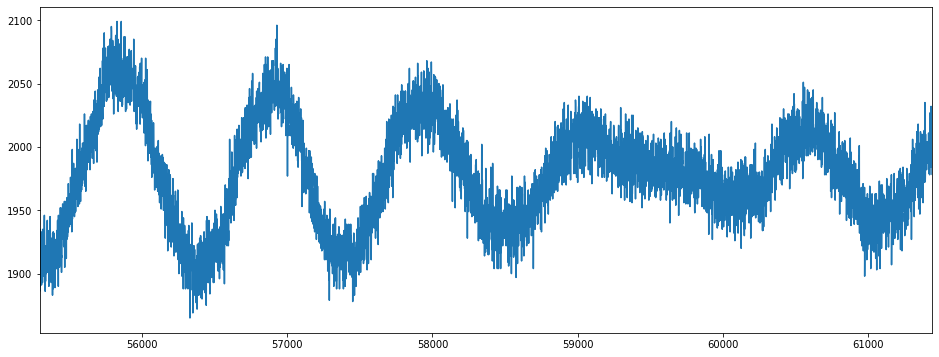

index:  209803
MAE:  0.03309433804209447
n_bunches       2556
bunch_index     2370
bunch_number    1749
chunk             19
Name: 4977, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7133/instability_data/07133_Inst_B1H_Q7_20180907_15h50m14s.h5


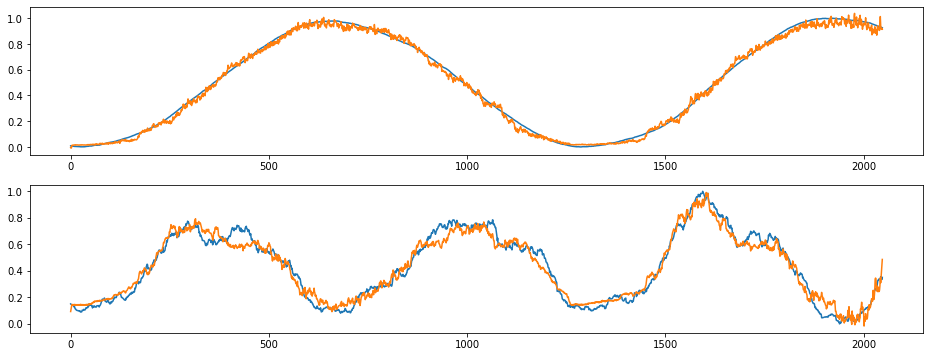

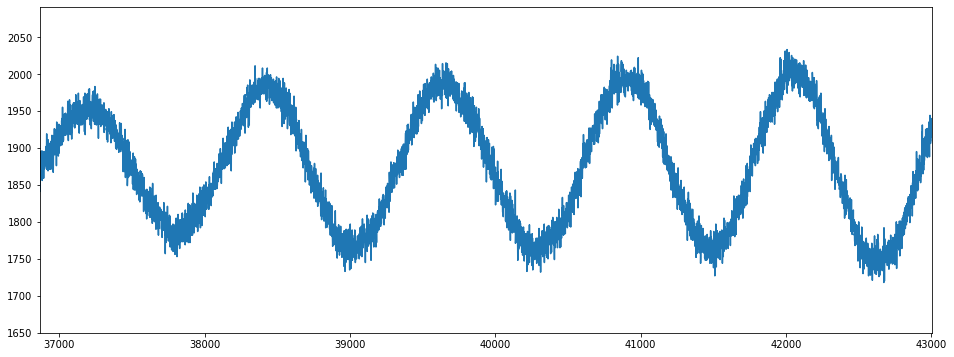

index:  221784
MAE:  0.033295257951725374
n_bunches        733
bunch_index     2848
bunch_number     603
chunk              1
Name: 350, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7468/instability_data/07468_Inst_B1H_Q7_20181123_20h55m20s.h5


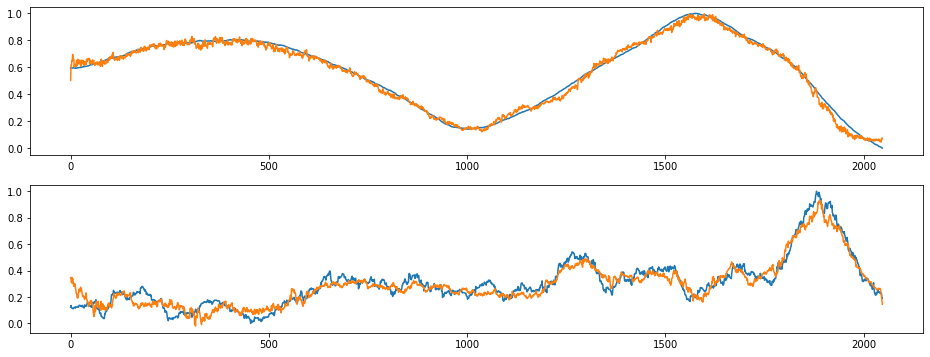

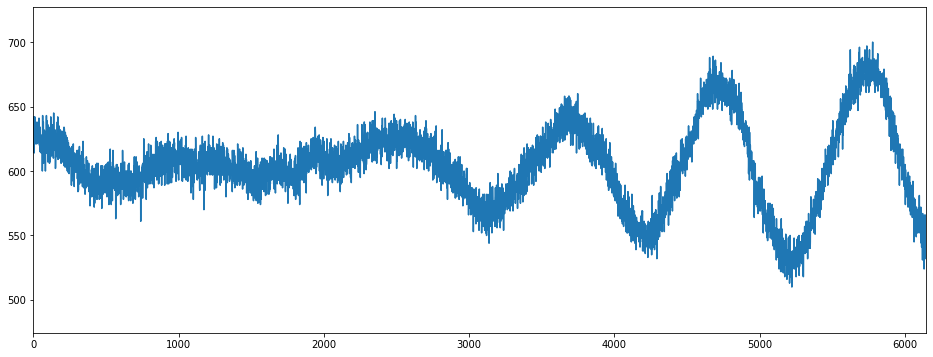

index:  51085
MAE:  0.03331843104093937
n_bunches        460
bunch_index     1576
bunch_number     210
chunk             21
Name: 5537, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/instability_data/07464_Inst_B1H_Q7_20181122_04h54m14s.h5


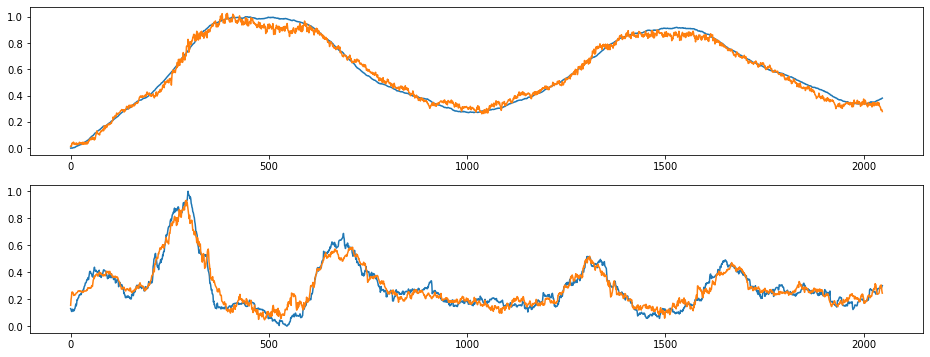

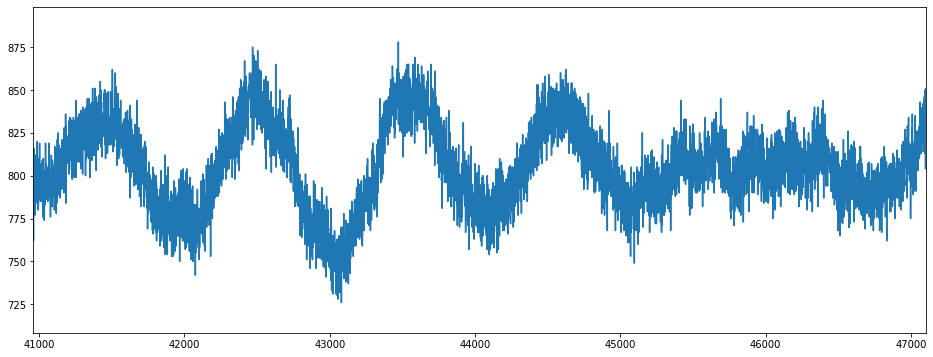

index:  271840
MAE:  0.03350558637349272
n_bunches       1868
bunch_index     1370
bunch_number     742
chunk             28
Name: 7332, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6348/instability_data/06348_Inst_B1H_Q7_20171030_23h23m14s.h5


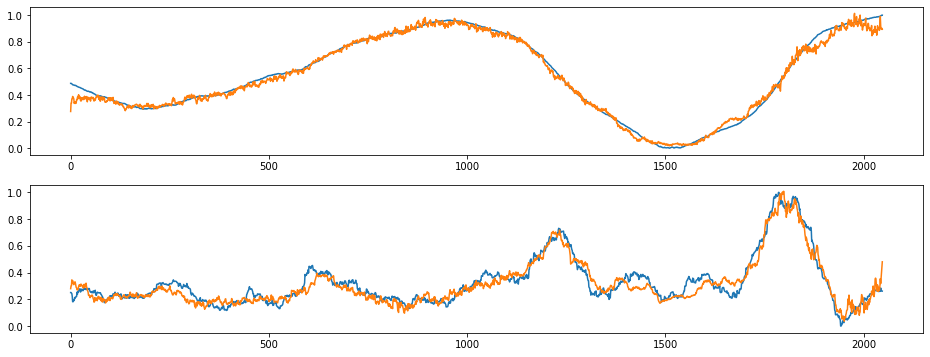

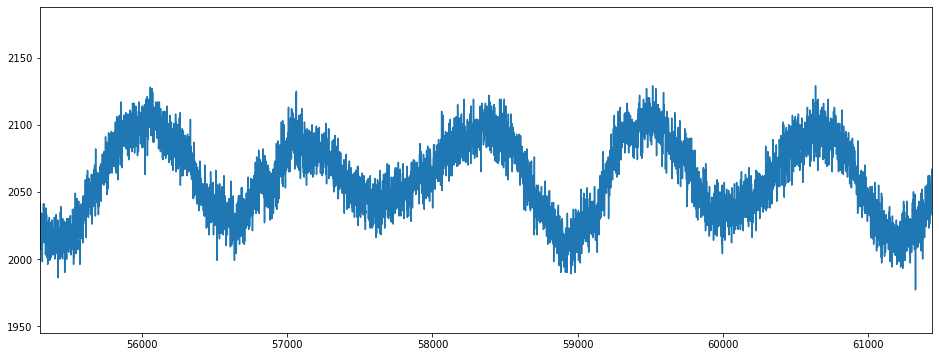

index:  254153
MAE:  0.03357147925103025
n_bunches        339
bunch_index     2696
bunch_number     265
chunk             20
Name: 5255, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6595/instability_data/06595_Inst_B1H_Q7_20180423_00h47m13s.h5


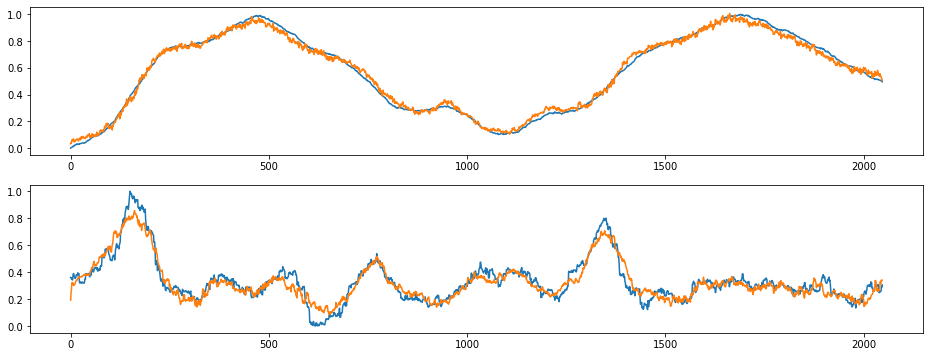

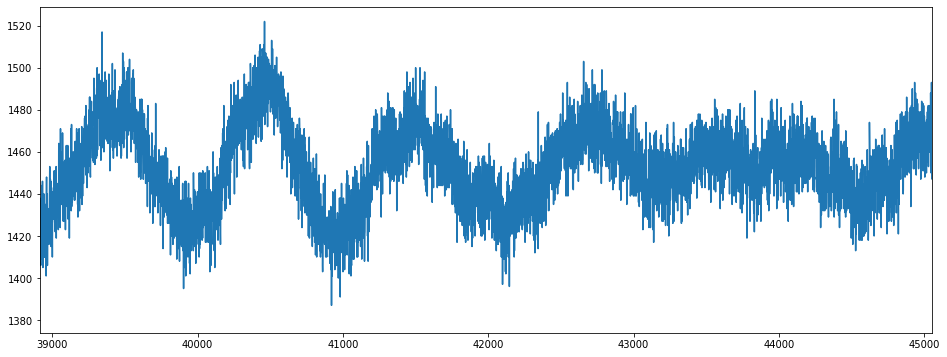

index:  339423
MAE:  0.033578184595699556
n_bunches        733
bunch_index     1807
bunch_number     376
chunk              8
Name: 2195, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7489/instability_data/07489_Inst_B1H_Q7_20181201_18h51m14s.h5


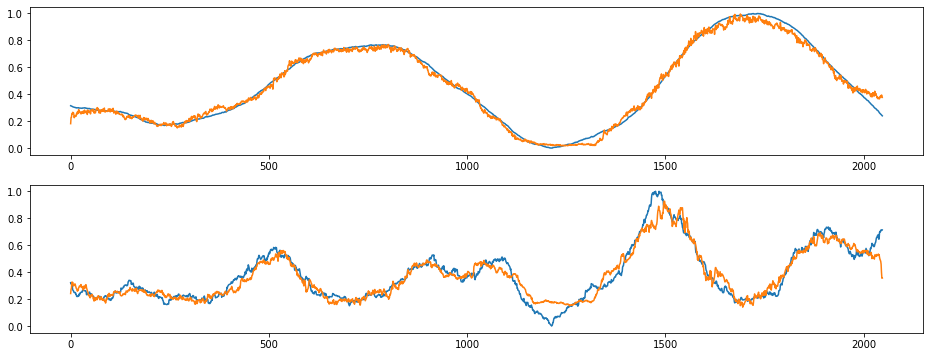

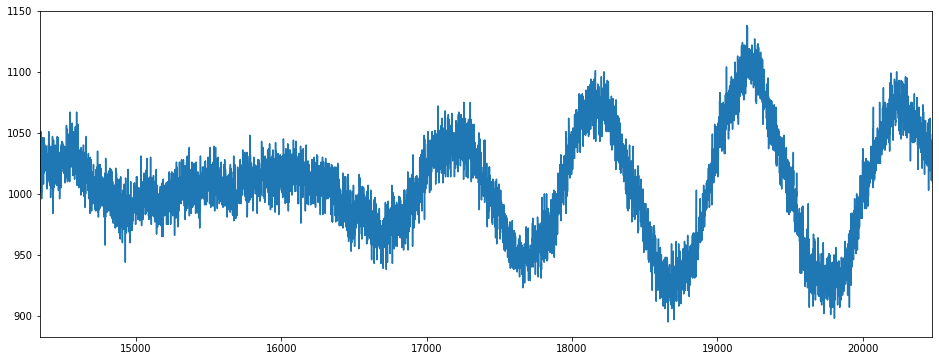

index:  190580
MAE:  0.03383657751020803
n_bunches       1836
bunch_index      646
bunch_number     334
chunk             30
Name: 7691, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_10h42m13s.h5


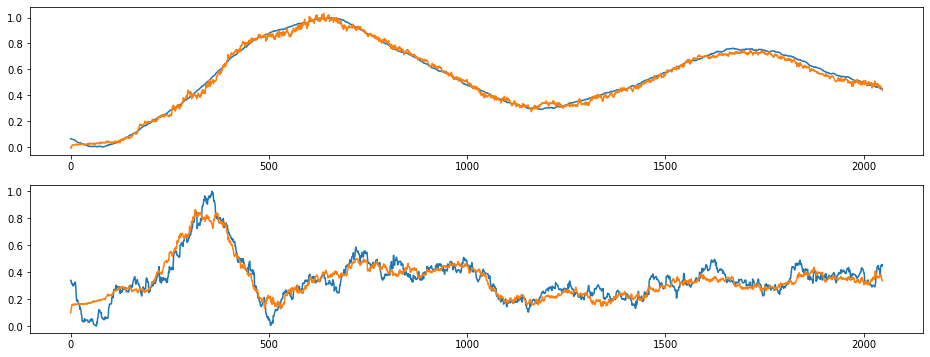

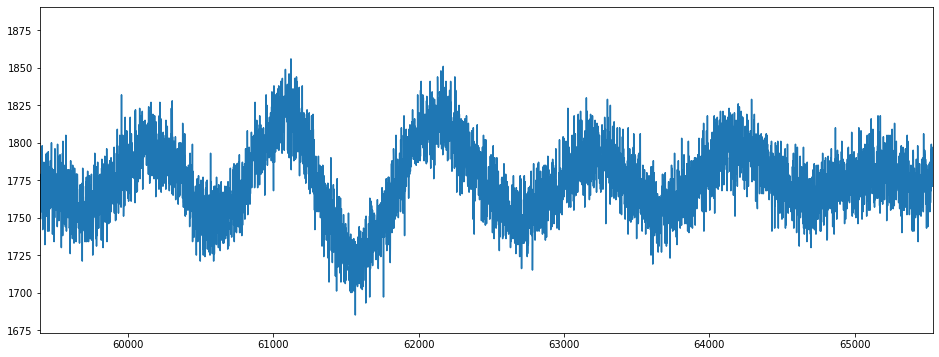

index:  82521
MAE:  0.033949826677538014
n_bunches       1836
bunch_index     1692
bunch_number     891
chunk             19
Name: 4966, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6272/instability_data/06272_Inst_B1H_Q7_20171005_02h31m14s.h5


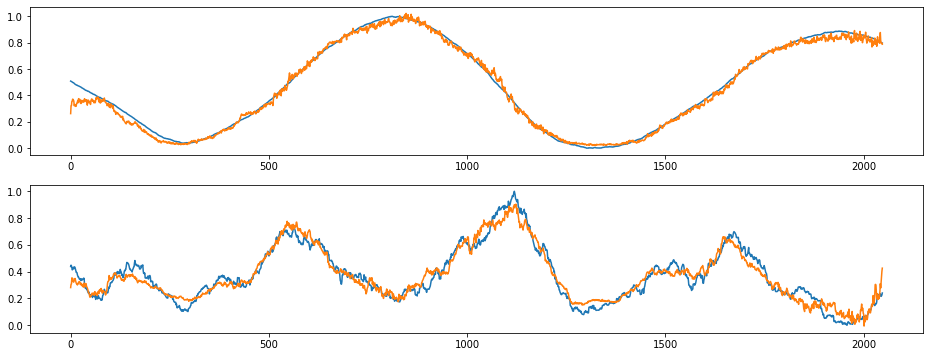

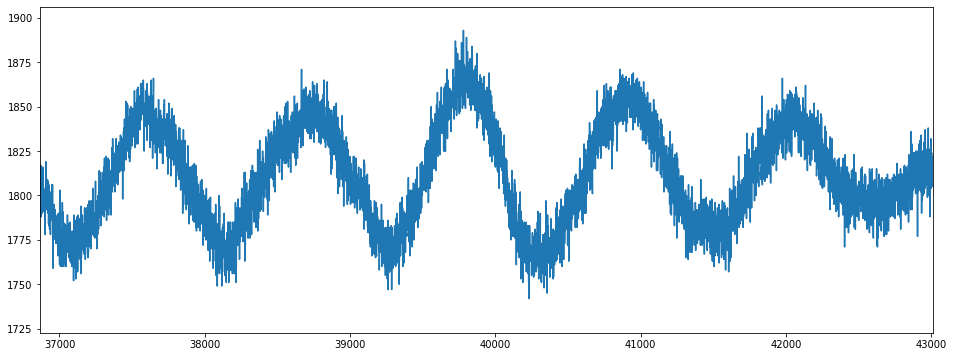

In [45]:
for i in range(1, 11):
    left_most = -i
    anomalous_index = max_MAE_indices[left_most]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# Signals around the peak

In [46]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  114057
MAE:  0.05412407134408584
n_bunches        408
bunch_index     1056
bunch_number     128
chunk             23
Name: 6030, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6436/instability_data/06436_Inst_B1H_Q7_20171130_06h38m09s.h5


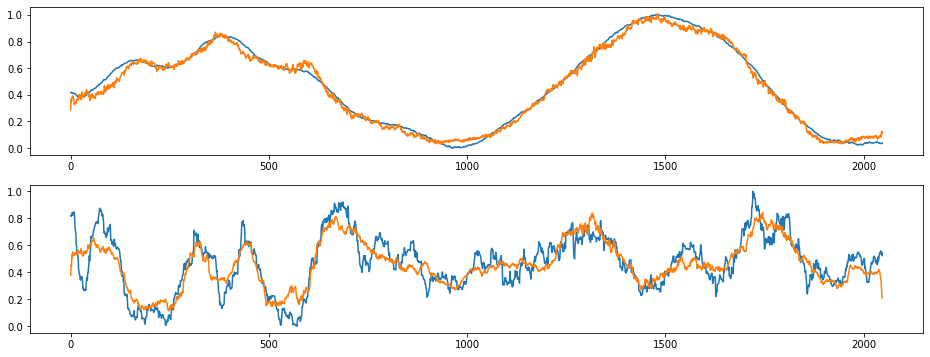

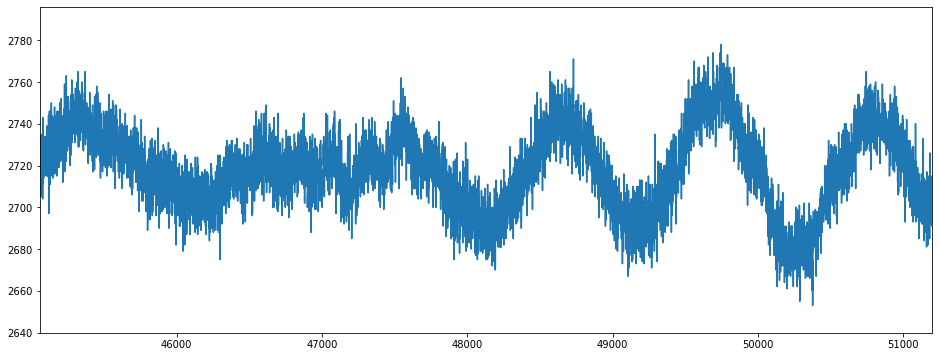

index:  189155
MAE:  0.05412398618035444
n_bunches       2175
bunch_index     1689
bunch_number    1045
chunk              9
Name: 2438, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6694/instability_data/06694_Inst_B1H_Q7_20180517_13h50m14s.h5


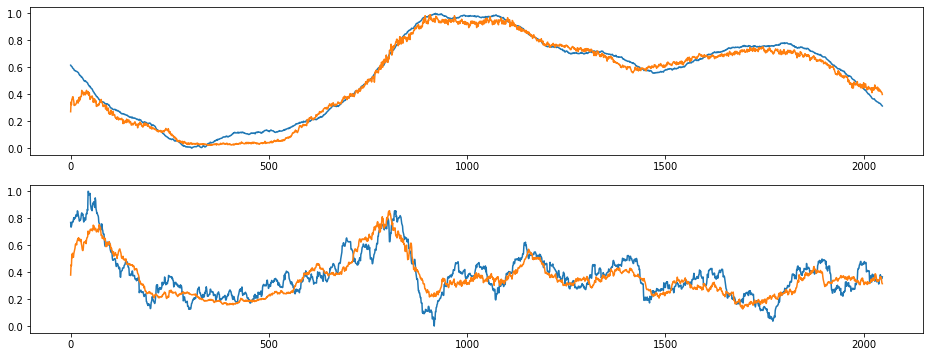

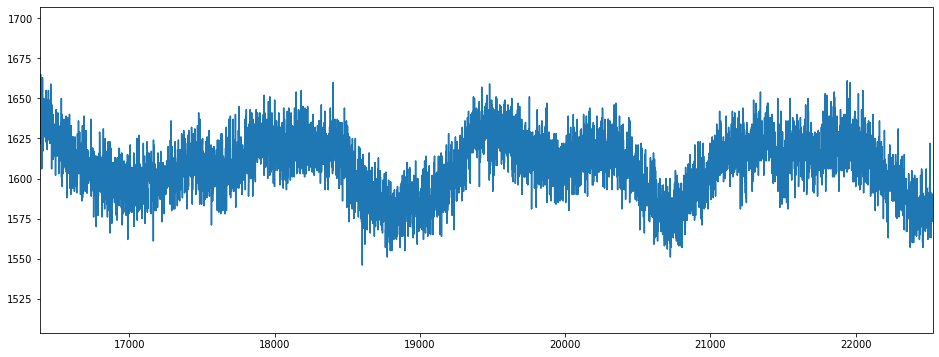

index:  81347
MAE:  0.054123966645117455
n_bunches          3
bunch_index     1785
bunch_number       1
chunk              5
Name: 1488, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6998/instability_data/06998_Inst_B1H_Q7_20180730_11h19m14s.h5


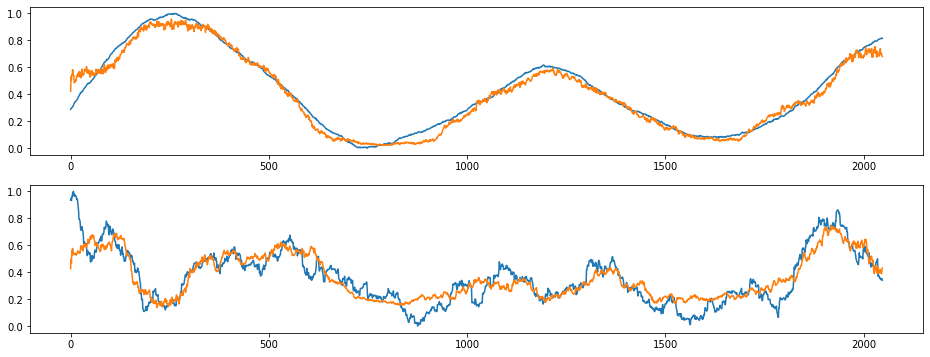

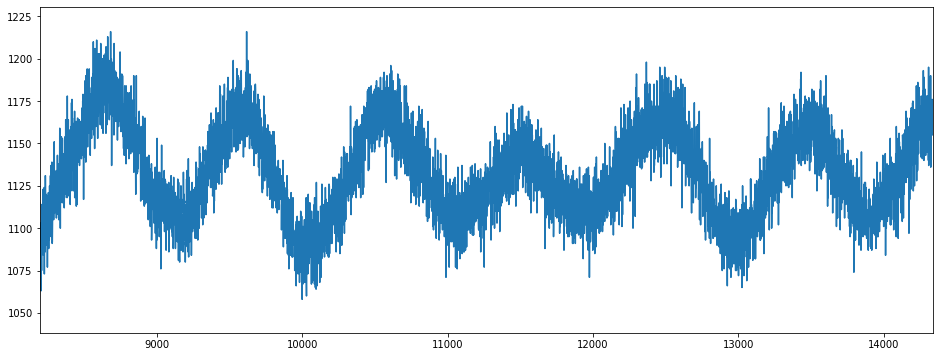

index:  105316
MAE:  0.05412414655062812
n_bunches        987
bunch_index     1999
bunch_number     541
chunk             30
Name: 7763, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6617/instability_data/06617_Inst_B1H_Q7_20180427_19h48m13s.h5


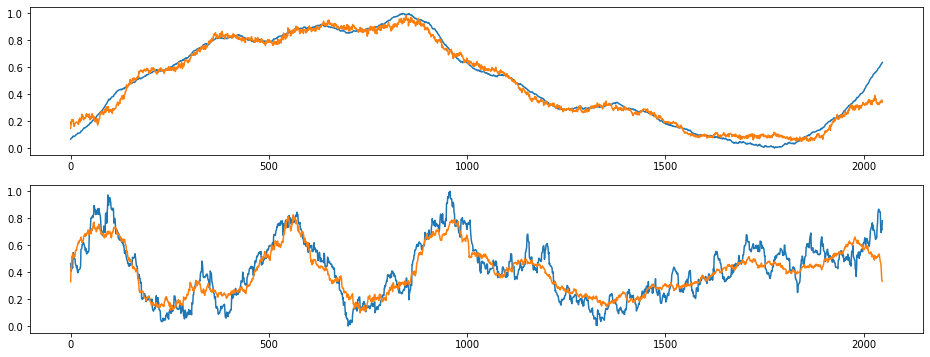

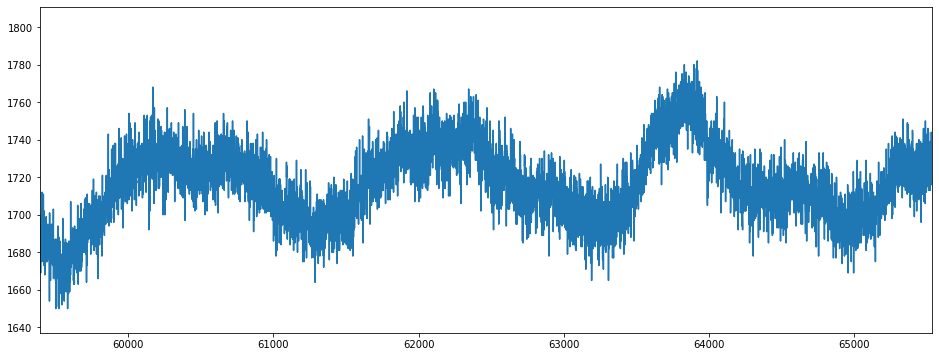

index:  21971
MAE:  0.05412414978036912
n_bunches        924
bunch_index     1212
bunch_number     889
chunk             17
Name: 4447, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7271/instability_data/07271_Inst_B1H_Q7_20181009_17h18m32s.h5


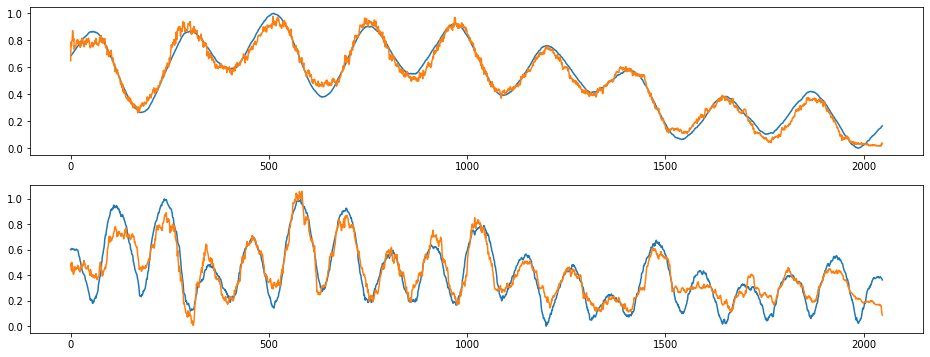

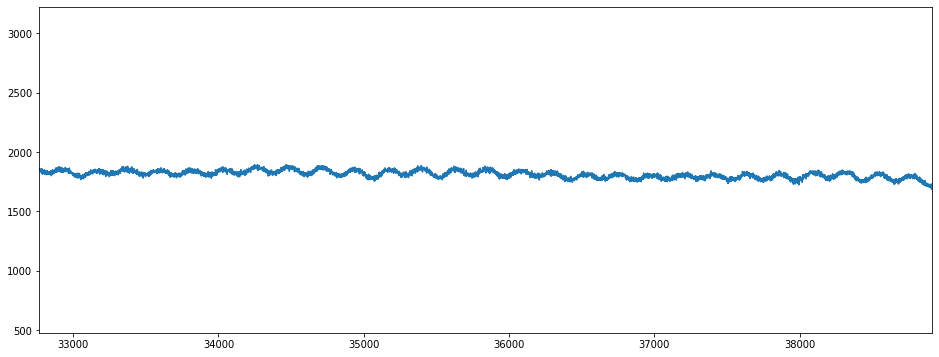

index:  167732
MAE:  0.05412394394292328
n_bunches        612
bunch_index     2209
bunch_number     410
chunk             15
Name: 3935, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7446/instability_data/07446_Inst_B1H_Q7_20181115_19h19m14s.h5


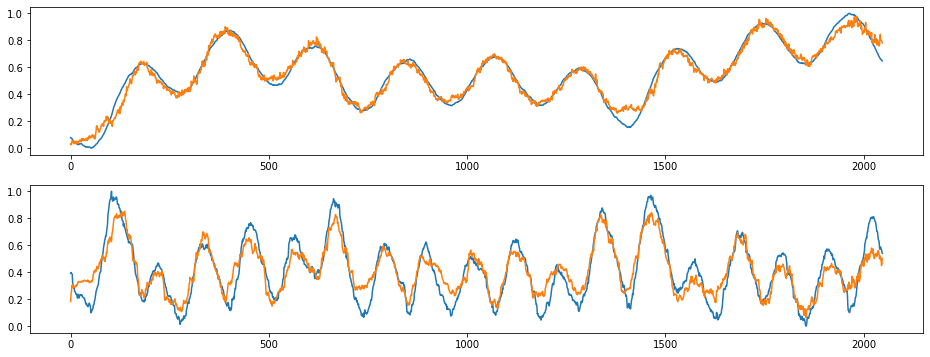

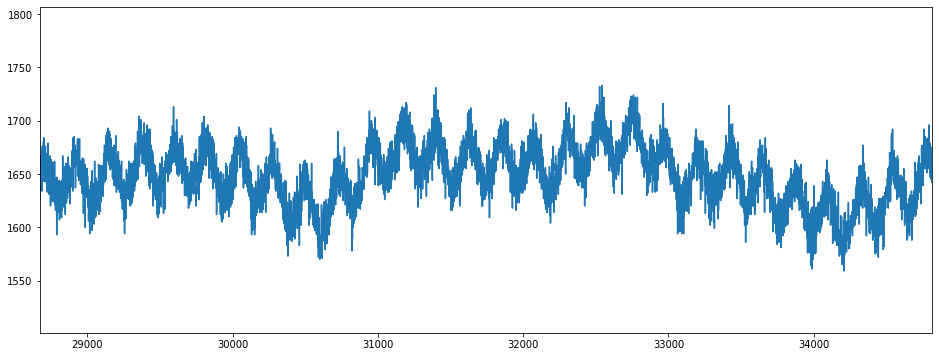

index:  266723
MAE:  0.05412416517444141
n_bunches       1868
bunch_index      759
bunch_number     418
chunk              4
Name: 1204, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6356/instability_data/06356_Inst_B1H_Q7_20171102_00h20m14s.h5


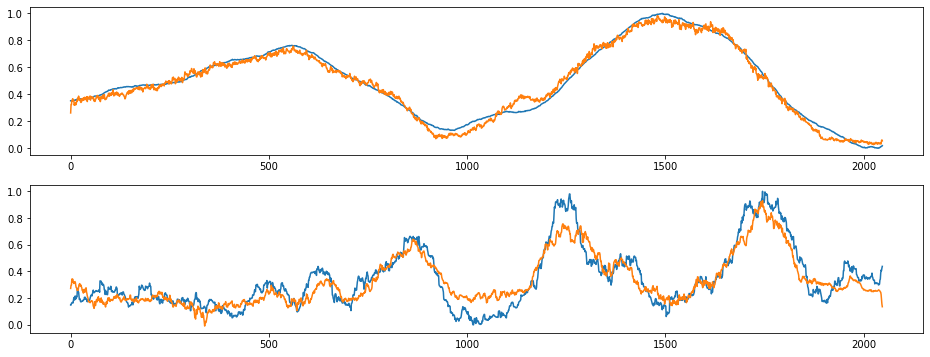

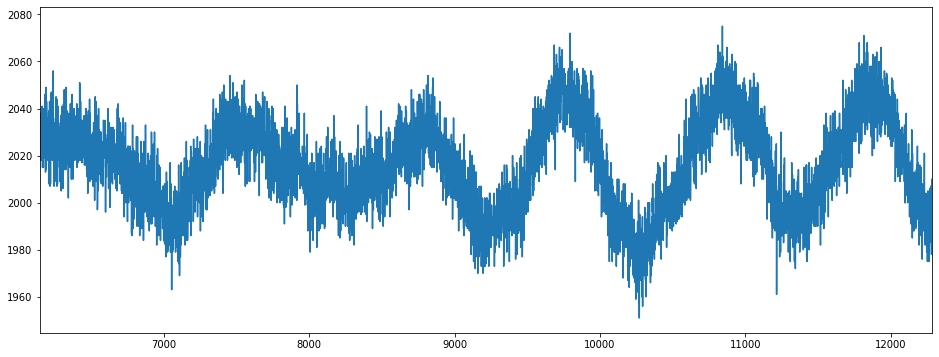

index:  4095
MAE:  0.054123912338697205
n_bunches       1212
bunch_index      136
bunch_number      86
chunk             17
Name: 4352, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6215/instability_data/06215_Inst_B1H_Q7_20170916_23h35m27s.h5


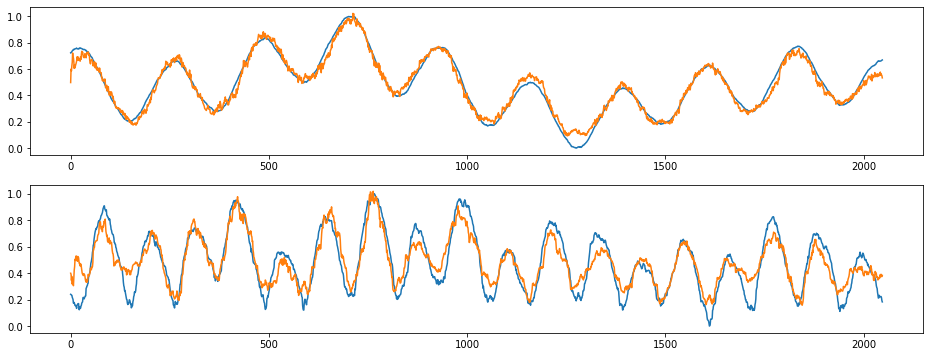

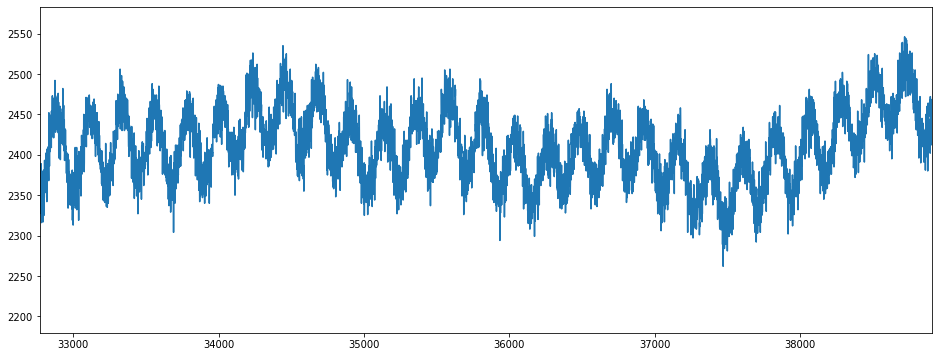

index:  286749
MAE:  0.05412391105558058
n_bunches       1916
bunch_index     2880
bunch_number    1581
chunk              6
Name: 1642, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6255/instability_data/06255_Inst_B1H_Q7_20170930_00h40m33s.h5


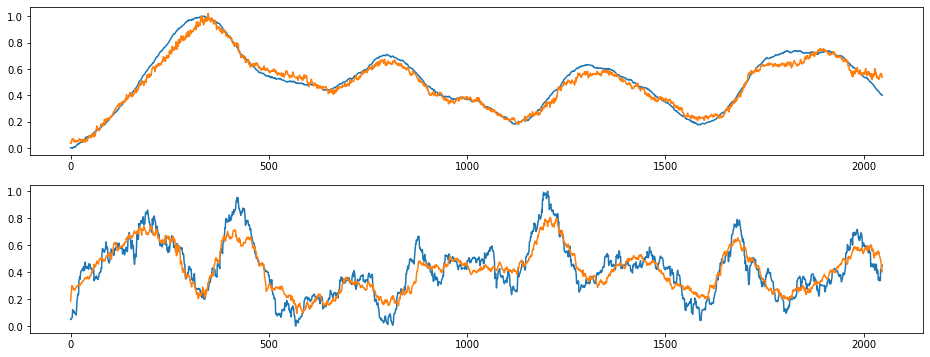

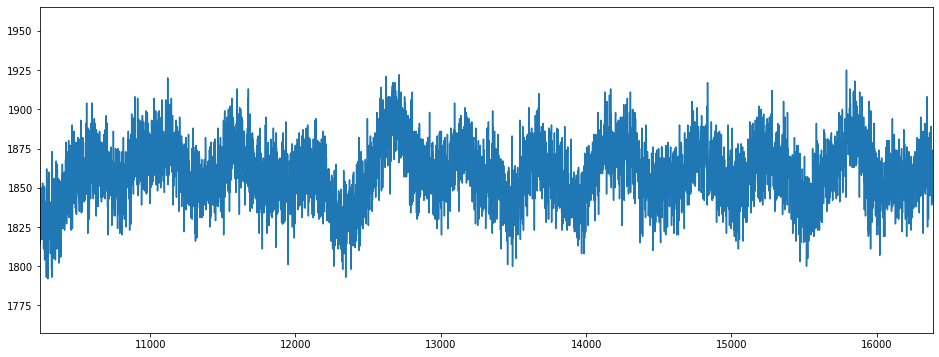

index:  1683
MAE:  0.054123866422929004
n_bunches        152
bunch_index     1967
bunch_number      86
chunk              9
Name: 2553, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7299/instability_data/07299_Inst_B1H_Q7_20181014_03h59m19s.h5


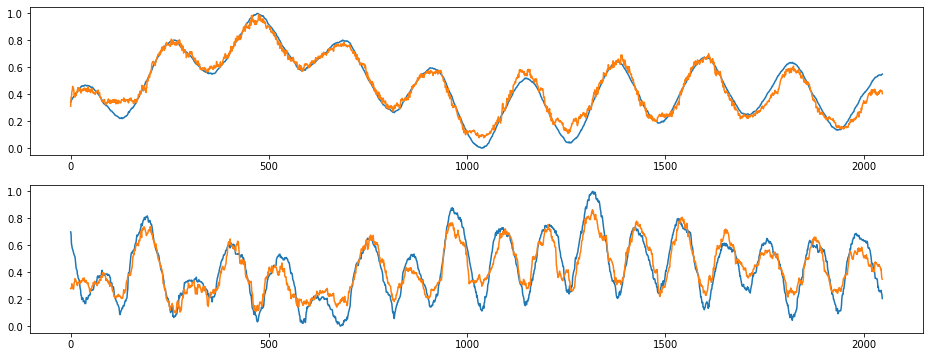

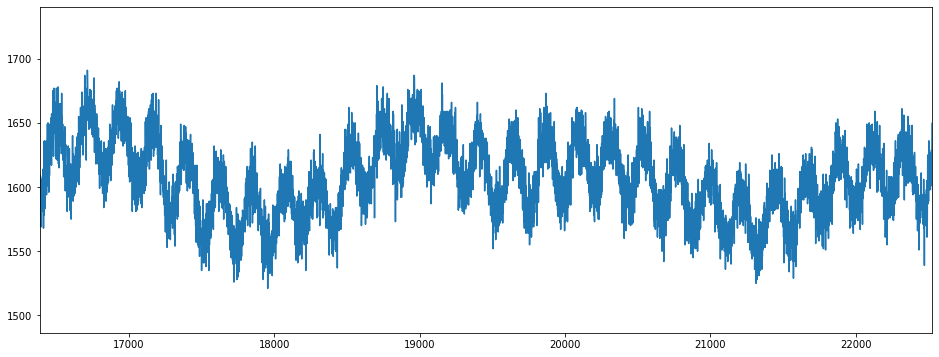

In [48]:
for i in range(10):
    anomalous_index = around_peak_indices[i]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# around a point

In [ ]:
around_point_indices = np.argsort(np.abs(MAE_train - 6))

In [ ]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[around_point_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()

# latent space encoding

In [ ]:
import keras

In [ ]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [ ]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

In [ ]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

In [ ]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

In [ ]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [ ]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [ ]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [ ]:
np.save(model_latent_space_file, latent_dataset)

In [ ]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [ ]:
np.save(model_train_dataset_file, train_dataset)

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)